In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Cambia il numero in base ai core del tuo PC

Impostazione dello stile per i grafici

In [528]:
sns.set(style="whitegrid")

=======================<br>
1. Caricamento e Pulizia del Dataset<br>
=======================

In [529]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.drop_duplicates(inplace=True)
pokemon.dropna(subset=['base_attack', 'base_defense', 'base_stamina'], inplace=True)

=======================<br>
2. Conversione e Codifica delle Colonne<br>
=======================<br>
Funzione per convertire le stringhe in liste

In [530]:
def convert_list(column):
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

Conversione delle colonne 'type', 'charged_moves' e 'fast_moves'

In [531]:
pokemon['type'] = convert_list(pokemon['type'])
pokemon['charged_moves'] = convert_list(pokemon['charged_moves'])
pokemon['fast_moves'] = convert_list(pokemon['fast_moves'])

One-hot encoding per i tipi di PokÃ©mon

In [532]:
mlb = MultiLabelBinarizer()
type_encoded = pd.DataFrame(mlb.fit_transform(pokemon['type']), columns=mlb.classes_)
pokemon = pd.concat([pokemon, type_encoded], axis=1)

Conteggio del numero di mosse per ciascun PokÃ©mon

In [533]:
pokemon['num_charged_moves'] = pokemon['charged_moves'].apply(len)
pokemon['num_fast_moves'] = pokemon['fast_moves'].apply(len)

Rimuovo le colonne originali non piÃ¹ necessarie

In [534]:
pokemon.drop(columns=['type', 'charged_moves', 'fast_moves'], inplace=True)

=======================<br>
3. Preparazione dei Dati per il Clustering<br>
=======================<br>
Selezione delle feature di battaglia:<br>
- base_attack (attacco)<br>
- base_defense (difesa)<br>
- base_stamina (HP)<br>
- num_charged_moves, num_fast_moves (set di mosse)

In [535]:
clustering_features = ['base_attack', 'base_defense', 'base_stamina', 'num_charged_moves', 'num_fast_moves']

Normalizzazione delle feature

In [536]:
scaler = StandardScaler()
pokemon_scaled = scaler.fit_transform(pokemon[clustering_features])

=======================<br>
4. Clustering con K-Means<br>
=======================

In [537]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
pokemon['cluster'] = kmeans.fit_predict(pokemon_scaled)

--- Grafico 1: Pairplot dei Cluster ---

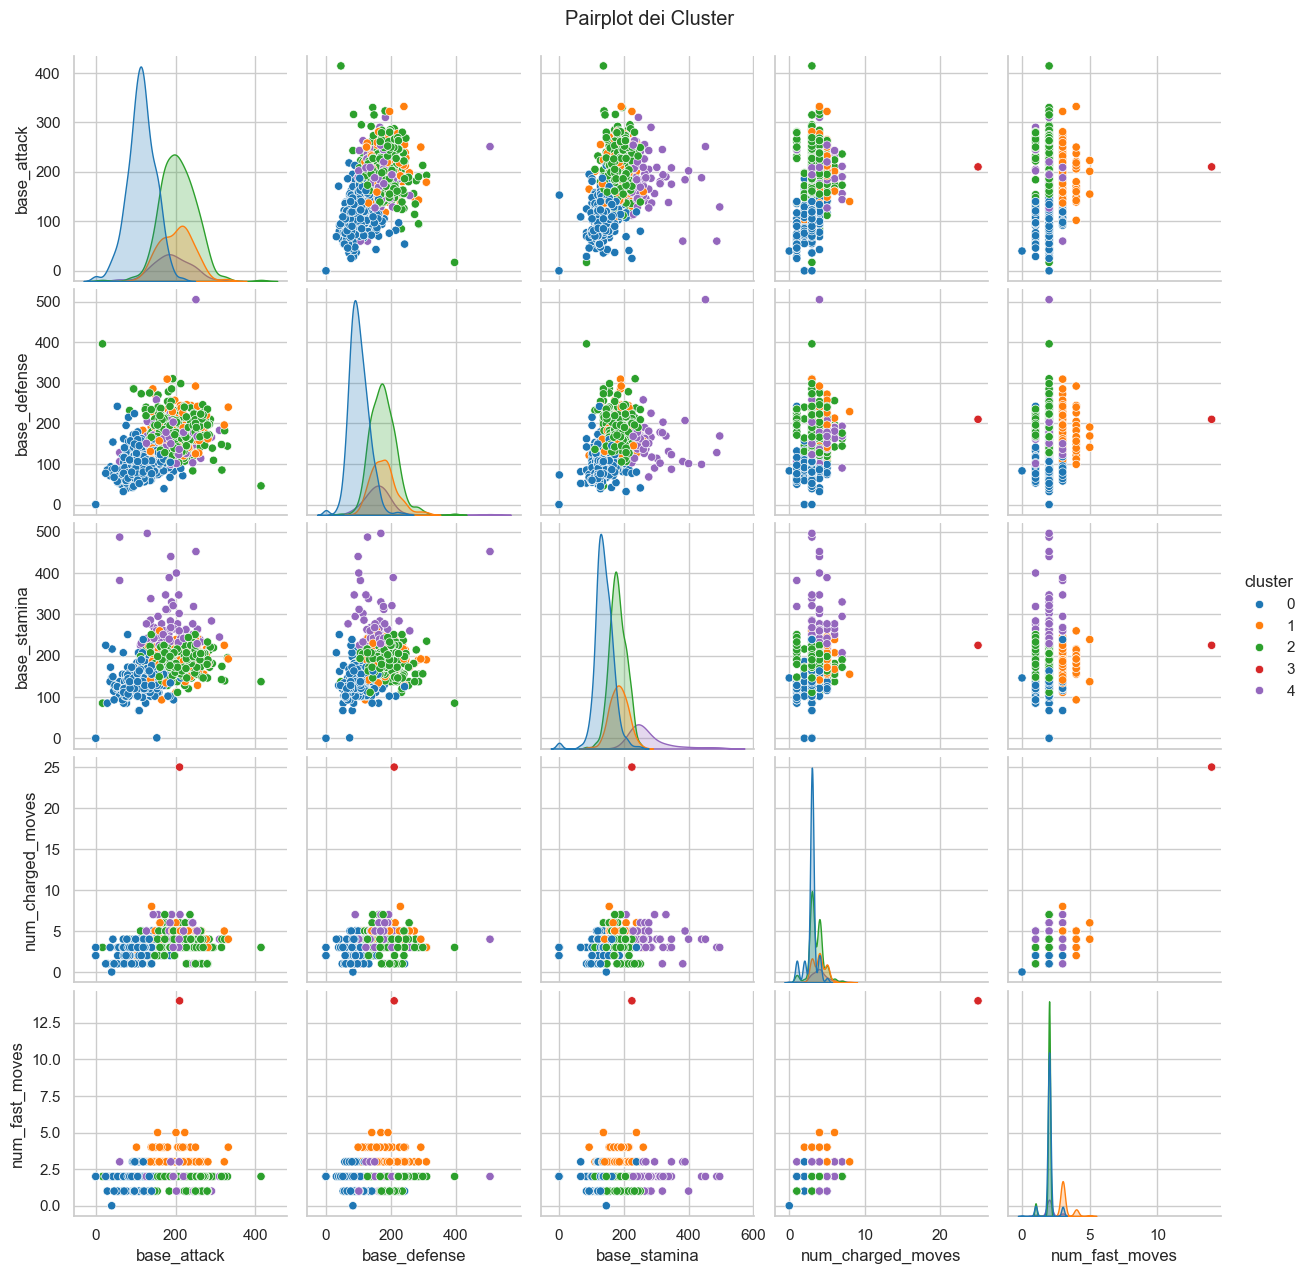

In [538]:
sns.pairplot(pokemon, vars=clustering_features, hue='cluster', palette='tab10')
plt.suptitle('Pairplot dei Cluster', y=1.02)
plt.show()

--- Grafico 2: Visualizzazione dei Cluster con PCA ---

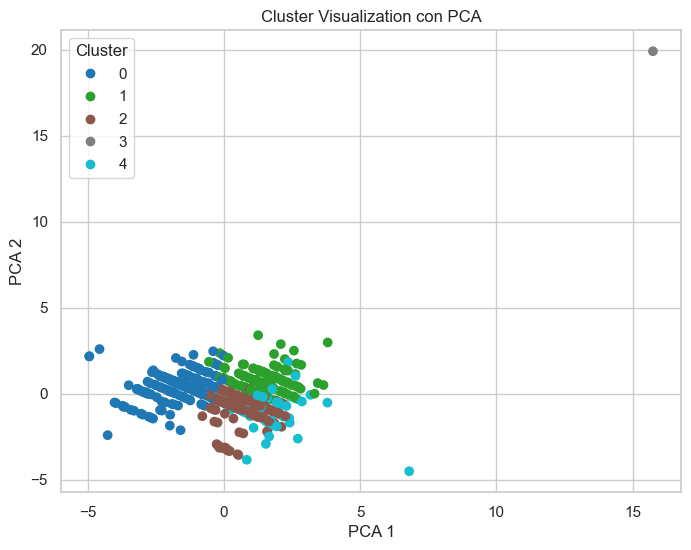

In [539]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pokemon_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=pokemon['cluster'], cmap='tab10')
plt.title('Cluster Visualization con PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

--- Grafico 3: Heatmap di Correlazione delle Feature di Battaglia ---

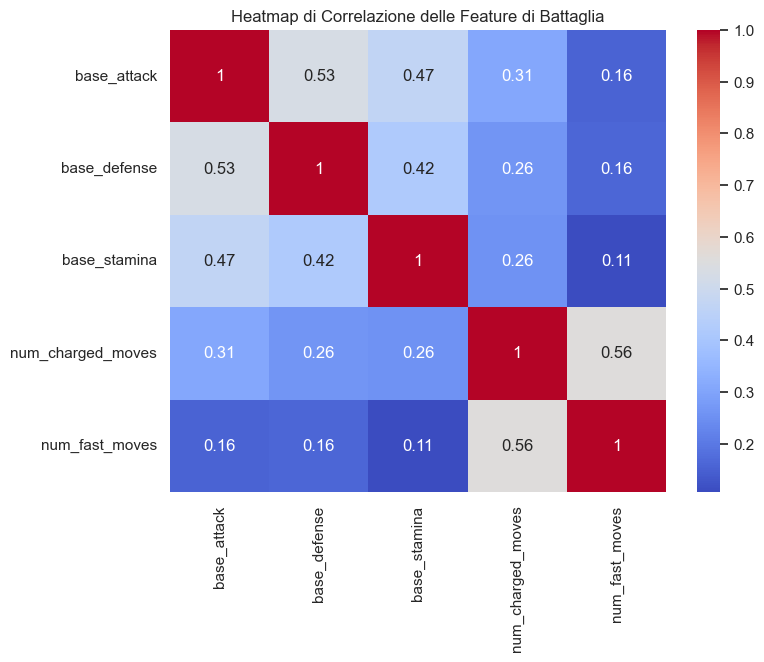

In [540]:
plt.figure(figsize=(8,6))
sns.heatmap(pokemon[clustering_features].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap di Correlazione delle Feature di Battaglia')
plt.show()

=======================<br>
5. Classificazione dell'Efficacia (PvP vs PvE)<br>
=======================<br>
Obiettivo: classificare i PokÃ©mon in base alla loro efficacia nel PvP o nel PvE,<br>
considerando statistiche, numero di mosse e bonus per alcuni tipi.

In [ ]:
def classify_pokemon(row):
    # Calcolo del punteggio PvP:
    pvp_score = (row['base_attack'] * 0.35 +
                 row['base_defense'] * 0.20 +
                 row['num_fast_moves'] * 0.25 +
                 row['min_pokemon_action_frequency'] * 0.20 +
                 row['max_pokemon_action_frequency'] * 0.10 +
                 row['dodge_probability'] * 0.30 +
                 row['attack_probability'] * 0.15)
    
    # Bonus extra per PvP in base ad alcuni indicatori
    if row['found_research']:
        pvp_score += 2
    if row['found_photobomb']:
        pvp_score += 1
    if row['found_evolution']:
        pvp_score += 1

    # Calcolo del punteggio PvE:
    pve_score = (row['base_stamina'] * 0.25 +
                 row['num_charged_moves'] * 0.15 +
                 row['max_cp'] * 0.10)
    
    # Bonus extra per PvE in base ad altri indicatori
    if row['found_raid']:
        pve_score += 3
    if row['found_egg']:
        pve_score += 1
    # Bonus aggiuntivo in base alla distanza (se piÃ¹ facilmente incontrabile, bonus per il PvE)
    if pd.notnull(row['distance']) and row['distance'] > 0:
        pve_score += (1 / row['distance']) * 0.5

    # Bonus in base al tipo (il bonus totale viene aggiunto integralmente al PvP e dimezzato al PvE)
    bonus = 0
    type_bonus = {
        'Bug': 2, 'Dark': 2, 'Dragon': 4, 'Electric': 5, 'Fairy': 3,
        'Fighting': 3, 'Fire': 5, 'Flying': 2, 'Ghost': 3, 'Grass': 3,
        'Ground': 2, 'Ice': 3, 'Normal': 1, 'Poison': 2, 'Psychic': 4,
        'Rock': 2, 'Steel': 3, 'Water': 3
    }
    for poke_type, bonus_value in type_bonus.items():
        if poke_type in row and row[poke_type] == 1:
            bonus += bonus_value
    pvp_score += bonus

    # Regolazione in base a 'candy_required': se presente (e non vuota), il PokÃ©mon potrebbe essere
    # considerato piÃ¹ raro o evolvibile, il che aggiunge un bonus al PvP e penalizza il PvE.
    if pd.notnull(row['candy_required']) and row['candy_required'] != "":
        pvp_score += 1
        pve_score -= 0.5
    return 'PvP' if pvp_score > pve_score else 'PvE'

Applicazione della funzione classify_pokemon per creare la colonna 'efficacy_category'

In [542]:
pokemon['efficacy_category'] = pokemon.apply(classify_pokemon, axis=1)

--- Grafico 4: Distribuzione delle Categorie (PvP vs PvE) ---

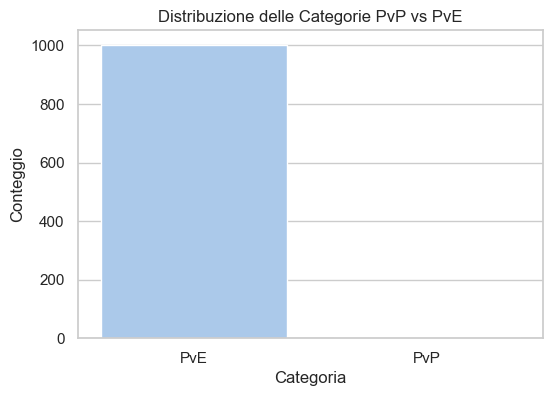

In [543]:
plt.figure(figsize=(6,4))
sns.countplot(x=pokemon['efficacy_category'], hue=pokemon['efficacy_category'], palette='pastel', legend=False)
plt.title('Distribuzione delle Categorie PvP vs PvE')
plt.xlabel('Categoria')
plt.ylabel('Conteggio')
plt.show()

Codifica della variabile target per la classificazione

In [544]:
le_efficacy = LabelEncoder()
pokemon['efficacy_encoded'] = le_efficacy.fit_transform(pokemon['efficacy_category'])

=======================<br>
6. Preparazione dei Dati per il Modello di Classificazione<br>
=======================<br>
Includiamo le feature numeriche, i conteggi delle mosse e anche le informazioni sui tipi.

In [545]:
type_features = list(type_encoded.columns)
classification_features = clustering_features + type_features

In [546]:
X_eff = pokemon[classification_features]
y_eff = pokemon['efficacy_encoded']

In [547]:
X_eff_train, X_eff_test, y_eff_train, y_eff_test = train_test_split(X_eff, y_eff, test_size=0.2, random_state=42)

=======================<br>
7. Addestramento e Valutazione del Modello di Classificazione<br>
=======================

In [548]:
clf_eff = RandomForestClassifier(n_estimators=100, random_state=42)
clf_eff.fit(X_eff_train, y_eff_train)
y_eff_pred = clf_eff.predict(X_eff_test)

Output testuali dei risultati

In [549]:
print("Efficacy (PvP vs PvE) Classification:")
labels = le_efficacy.transform(le_efficacy.classes_)
print(confusion_matrix(y_eff_test, y_eff_pred, labels=labels))
print(classification_report(y_eff_test, y_eff_pred, target_names=le_efficacy.classes_, labels=labels, zero_division=0))

Efficacy (PvP vs PvE) Classification:
[[202   0]
 [  0   0]]
              precision    recall  f1-score   support

         PvE       1.00      1.00      1.00       202
         PvP       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00       202
   macro avg       0.50      0.50      0.50       202
weighted avg       1.00      1.00      1.00       202



--- Grafico 5: Confusion Matrix Heatmap (Efficacy) ---

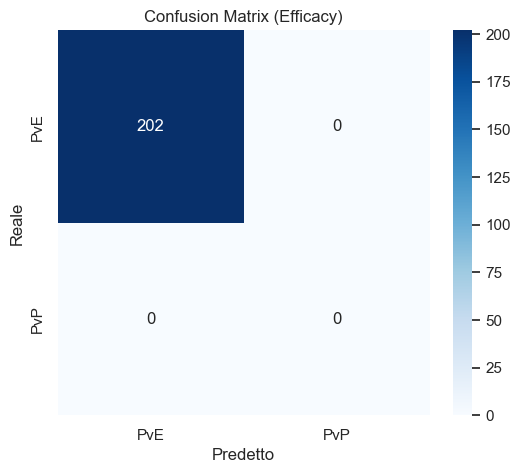

In [550]:
plt.figure(figsize=(6,5))
conf_matrix_eff = confusion_matrix(y_eff_test, y_eff_pred, labels=labels)
sns.heatmap(conf_matrix_eff, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_efficacy.classes_, yticklabels=le_efficacy.classes_)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix (Efficacy)')
plt.show()

--- Grafico 6: Importanza delle Feature (Efficacy Classification) ---

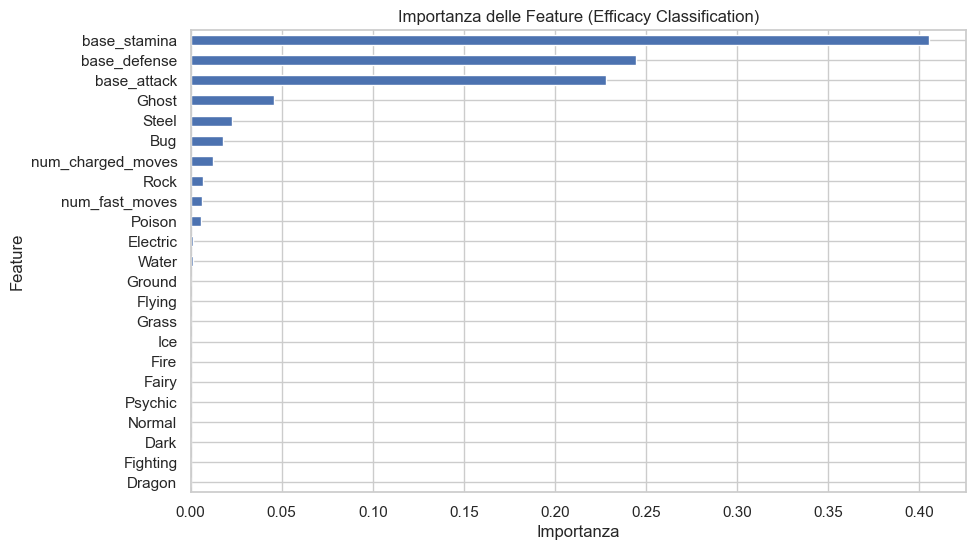

In [551]:
plt.figure(figsize=(10,6))
efficacy_features = classification_features
importances_eff = pd.Series(clf_eff.feature_importances_, index=efficacy_features)
importances_eff.sort_values().plot(kind='barh')
plt.title('Importanza delle Feature (Efficacy Classification)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.show()

--- Grafico 7: PCA delle Feature (Efficacy Classification) ---

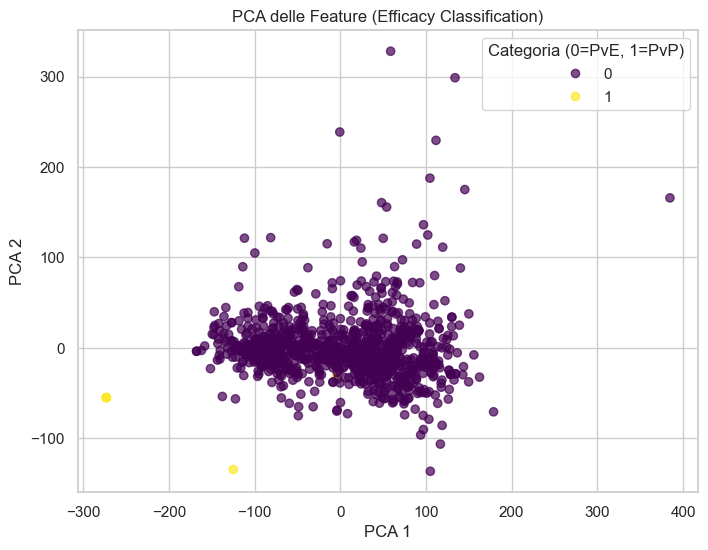

In [552]:
pca_eff = PCA(n_components=2)
X_eff_pca = pca_eff.fit_transform(X_eff)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_eff_pca[:, 0], X_eff_pca[:, 1], c=y_eff, cmap='viridis', alpha=0.7)
plt.title('PCA delle Feature (Efficacy Classification)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(*scatter.legend_elements(), title="Categoria (0=PvE, 1=PvP)")
plt.show()

=======================<br>
8. Classificazione per la RaritÃ <br>
=======================<br>
Per la classificazione della raritÃ  usiamo le feature di battaglia e anche i tipi (one-hot encoded),<br>
dato che questi dati sono separati dall'efficacia e non vanno "mescolati" nella stessa colonna target.

In [553]:
le_rarity = LabelEncoder()
pokemon['rarity_encoded'] = le_rarity.fit_transform(pokemon['rarity'])

Utilizziamo sia le feature di battaglia che quelle relative ai tipi

In [554]:
rarity_features = clustering_features + list(type_encoded.columns)
X_rarity = pokemon[rarity_features]
y_rarity = pokemon['rarity_encoded']

In [555]:
X_rarity_train, X_rarity_test, y_rarity_train, y_rarity_test = train_test_split(X_rarity, y_rarity, test_size=0.2, random_state=42)

In [556]:
clf_rarity = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rarity.fit(X_rarity_train, y_rarity_train)
y_rarity_pred = clf_rarity.predict(X_rarity_test)

In [557]:
print("Rarity Classification:")
print(confusion_matrix(y_rarity_test, y_rarity_pred))
print(classification_report(y_rarity_test, y_rarity_pred, target_names=le_rarity.classes_, zero_division=0))

Rarity Classification:
[[  5   0   8   0]
 [  0   1   3   0]
 [  1   0 183   0]
 [  0   0   1   0]]
              precision    recall  f1-score   support

   Legendary       0.83      0.38      0.53        13
      Mythic       1.00      0.25      0.40         4
    Standard       0.94      0.99      0.97       184
 Ultra beast       0.00      0.00      0.00         1

    accuracy                           0.94       202
   macro avg       0.69      0.41      0.47       202
weighted avg       0.93      0.94      0.92       202



--- Grafico 8: Confusion Matrix Heatmap (Rarity) ---

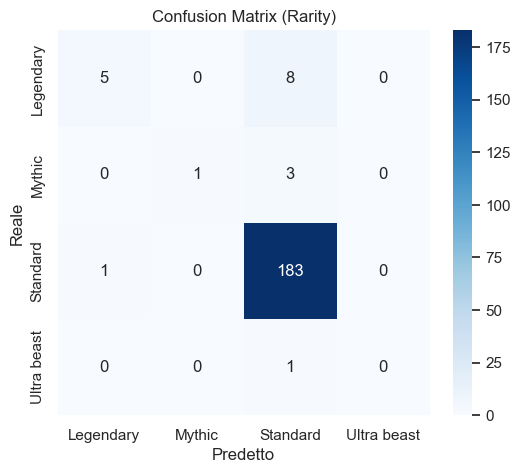

In [558]:
plt.figure(figsize=(6,5))
conf_matrix_rarity = confusion_matrix(y_rarity_test, y_rarity_pred)
sns.heatmap(conf_matrix_rarity, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_rarity.classes_, yticklabels=le_rarity.classes_)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix (Rarity)')
plt.show()

--- Grafico 9: Importanza delle Feature (Rarity Classification) ---

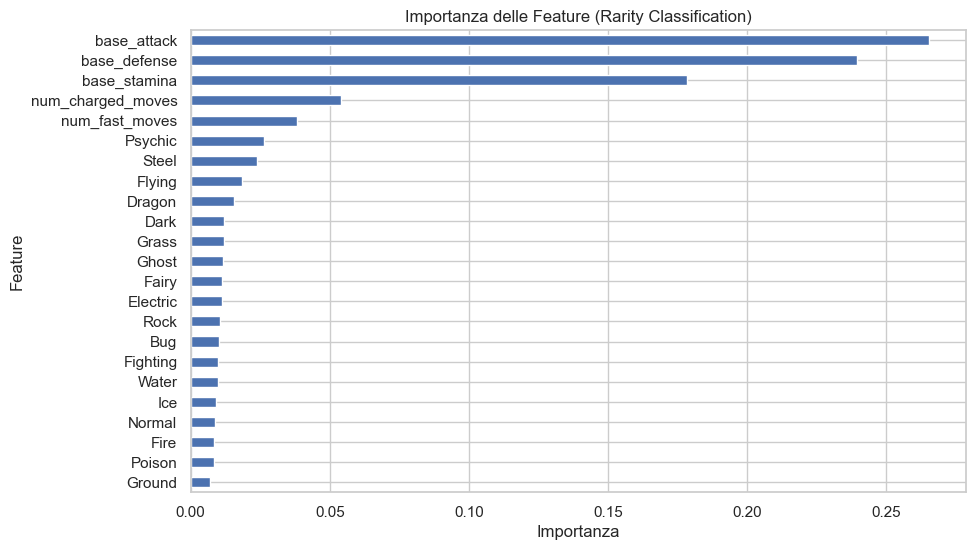

In [559]:
plt.figure(figsize=(10,6))
importances_rarity = pd.Series(clf_rarity.feature_importances_, index=rarity_features)
importances_rarity.sort_values().plot(kind='barh')
plt.title('Importanza delle Feature (Rarity Classification)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.show()

--- Grafico 10: PCA delle Feature (Rarity Classification) ---

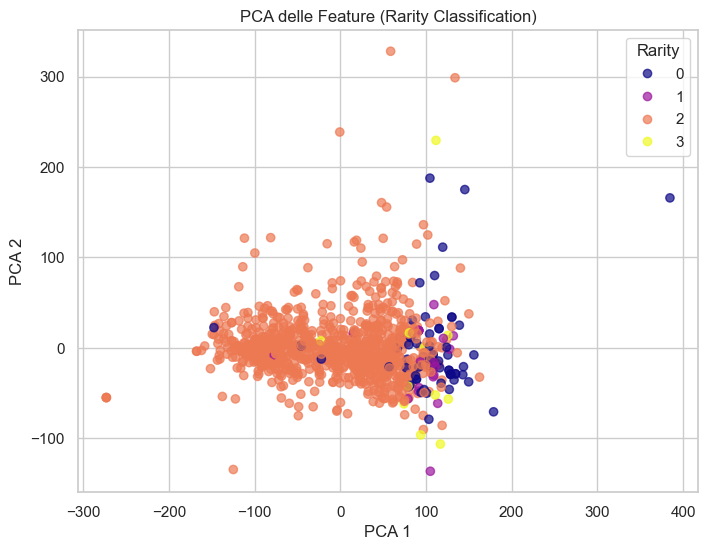

In [560]:
pca_rarity = PCA(n_components=2)
X_rarity_pca = pca_rarity.fit_transform(X_rarity)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_rarity_pca[:, 0], X_rarity_pca[:, 1], c=y_rarity, cmap='plasma', alpha=0.7)
plt.title('PCA delle Feature (Rarity Classification)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(*scatter.legend_elements(), title="Rarity")
plt.show()